In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
import os
import random
import re

In [2]:
#load needed dataframes:
#Dataframe with information about character game appearances:
with open('df_meta.pickle', 'rb') as f:
    df_meta = pickle.load(f)
#Dataframe with character text:
with open('df_final.pickle', 'rb') as f:
    df_text = pickle.load(f)
#Directed graph of all characters
with open('DG.pickle', 'rb') as f:
    DG = pickle.load(f)

## Sentiment over time


We load the wordlist with sentiment scores (as we did in assignment 2).

In [3]:
#Load LabMT word list as dataframe:
df_happy = pd.read_csv('Data_Set_S1.txt', skiprows=2, sep="\t")

First we define some functions that help us calculate the sentiment score.

In [4]:
def text2sentiment_freqdist(freqdist_dic):
    #function taken from our assignment 2
    
    # total happiness score
    happiness_score = 0
    # total count of tokens included in the sentiment score
    w = 0
    
    # iterate over tokens in freqdist
    for token in freqdist_dic.keys():
        # check if token is in the dataframe
        if token in list(df_happy['word']):
            token = token.lower()
            
            # get sentiment score of word and multiply it with how many times it appears in the text 
            score = float(df_happy.loc[df_happy['word'] == token]['happiness_average'])
            happiness_score += freqdist_dic[token]*score
            
            # add how many times the token appears to total count
            w += freqdist_dic[token]
    
    # if total token count is 0, return 0. Else divide total happiness score with total token count
    if w == 0:
           return 0
    else:
        return happiness_score / w

In [5]:
#the following is also based on assignment 2 code:
for i, name in enumerate(tqdm(df_text['Name'])):   
    if name in DG.nodes():
        # tokenize text from character page and turn into FreqDist dictionary
        tokens = df_text['Clean Text'].iloc[i].split()
        freqdist_dic = nltk.FreqDist(tokens)
        
        # assign sentiment score as new attribute in the graph
        sentiment_score = text2sentiment_freqdist(freqdist_dic)
        DG.nodes()[name]['sentiment'] = sentiment_score

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [18:34<00:00,  1.76it/s]


In [6]:
mean_sent=np.mean([value for (name,value) in list(DG.nodes('sentiment'))]) #Find mean sentiment score for all characters
print('Mean sentiment score: ',mean_sent)

Mean sentiment score:  5.253193968264166


Above we have the mean sentiment score for all characters in the data set. It is lower than the average sentiment score for the wordlist that is used to calculate the sentiment scores.

In [7]:
df_happy['happiness_average'].values.mean()#Mean sentiment for the word list that the sentiment scores are based on

5.375239679123459

In [8]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS'] #list of games/expansions considered for sentiment analysis.


In [9]:
#dictionaries for storing sentiment scores
games_sent = {}
games_sent_horde = {}
games_sent_alliance = {}
#Find sentiment scores for all Horde and Alliance characters that appear in a given game and append the score to the list of their respective faction. 
for game in tqdm(games): 
    h = []
    a = []
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h.append(DG.nodes()[name]['sentiment'])
    games_sent_horde[game]=np.mean(h)#Calculate mean sentiment score for Horde characters in the given game.
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a.append(DG.nodes()[name]['sentiment'])
    games_sent_alliance[game]=np.mean(a)#Calculate mean sentiment score for Alliance characters in the given game.
games_sent = {'Horde':games_sent_horde, 'Alliance':games_sent_alliance}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.23it/s]


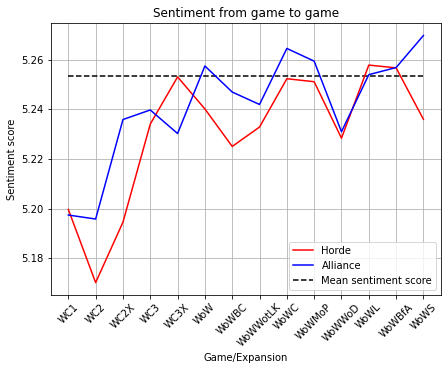

In [10]:
#plot of mean sentiment
plt.figure(figsize=(7,5))
plt.plot(games_sent['Horde'].values(),'r',label='Horde')
plt.plot(games_sent['Alliance'].values(),'b',label='Alliance')
plt.title('Sentiment from game to game')

plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean sentiment score')
plt.legend()
plt.show()

In [162]:
#save Graph with sentiment scores as attribute
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
#Count how many characters of each faction that appear in each game.
#This is done similarly to how the sentiment score was calculated.
#For each character in a given game that belongs to either the Horde or the Alliance, the respective factions counter ticks up
#THis count only consideres major characters, since the game metadata only exists for them.
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h_count +=1
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=1
    #the counts for each faction is saved for each game
    game_fac_h[game]=h_count
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.34it/s]


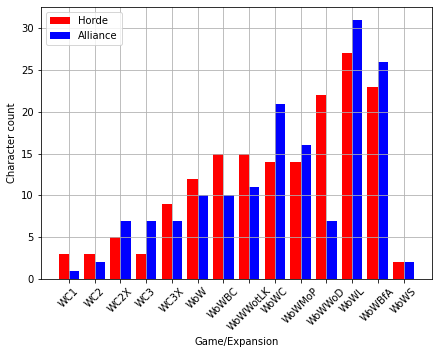

In [12]:
#Bar plot of Horde and Alliance character count.
horde_count=list(game_fac['Horde'].values())
alliance_count = list(game_fac['Alliance'].values())
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,horde_count,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,alliance_count,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Character count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


We want to understand what kind of characters gets high and low sentiment scores. We threshold the sentiment scores so only the most positive and negative texts remain.

In [13]:
evil_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value<5])
good_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value>5.6])
print(len(good_names),len(evil_names))

11 30


We see that there are more characters with a sentiment score under 5 than characters with a sentiment score over 5.6.
By reading the wiki-pages of the cahraceters with the lowest and highest sentiment scores, we see that they have very short texts. We now want to see if length of a characters wiki-page has an impact on the sentiment score.

In [14]:
#Calculate the mean ammount of characters in a text for characters with a sentiment score below 5 compared to those with a sentiment score above 5.3, and all characters
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in good_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in evil_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in df_text['Name']]))

863.5454545454545
632.8
5676.060173380928


We can see that the characters we found with our threshold of sentiment scores before, have relatively short texts in terms of amount of characters.

In [15]:
#Sort characters by sentiment scores
temp_sent_list = sorted([(value, name) for (name,value) in list(DG.nodes('sentiment'))])
sorted_sent = [value for (value,name) in temp_sent_list]
sorted_len = [len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) for (value,name) in temp_sent_list]

We have now sorted the characters by sentiment score and found the length of their associated text by the amount of words(tokens). We can now plot the rolling average text length by the sentiment scores. The rolling average takes a window of 100 samples (result is assigned to the right-most index in the window) and averages them with a uniform weigthing. This smoothes the plot, making it easier to see the underlying trend.

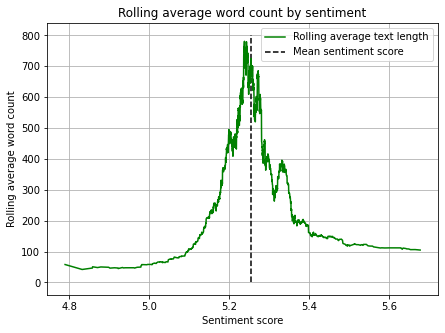

In [24]:
sent_len_df = pd.DataFrame(np.array([sorted_sent, sorted_len]).T,columns=['Sentiment_score','Length_of_text'])
# print(sent_len_df['Length_of_text'])
rolled_series = sent_len_df['Length_of_text'].rolling(100,min_periods=1).mean()
# print(rolled_series)
plt.figure(figsize=(7,5))
plt.plot(sorted_sent,rolled_series,'g',label='Rolling average text length')
# plt.yscale('log')
plt.title('Rolling average word count by sentiment')
plt.ylabel('Rolling average word count')
plt.xlabel('Sentiment score')
plt.vlines(mean_sent,ymin=0,ymax=800, color='black',linestyles='--',label='Mean sentiment score')
plt.grid()
plt.legend()

This shows us that the sentiment score of a text approaches the mean when as the text gets longer. So a long text will be more likely to have a sentiment score of around 5.25. 

In [25]:
#Find text length for each character appearing in each game
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:#find Horde characters that appeared in the given game
            h_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) #Add their texts word count to the sum
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split()))
    #save the cumulative text lenght in terms of amount of tokens for each faction for each game.
    game_fac_h[game]=h_count 
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.81it/s]


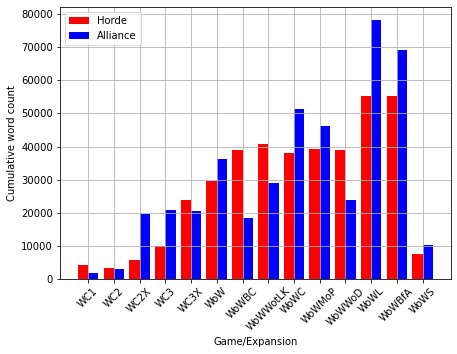

In [26]:
#plot cumulative word count
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,list(game_fac['Horde'].values()),color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,list(game_fac['Alliance'].values()),color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Cumulative word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


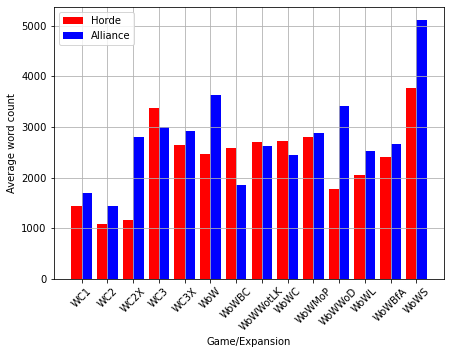

In [27]:
#Calculate mean length of text(word count) for each character of each faction in a given game.
h_val = np.divide(np.array(list(game_fac['Horde'].values())),np.array(horde_count))
a_val = np.divide(np.array(list(game_fac['Alliance'].values())),np.array(alliance_count))
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,h_val,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,a_val,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Average word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()

We want to see the summary statistics of the sentiment scores for Horde and Alliance (code adapted from our assignment2).

In [28]:
#Calculate the mean sentiment scores of each faction. Includes all characters from all games + non-major characters.
h_sent = []
a_sent = []
for name in Horde:
    h_sent.append(DG.nodes()[name]['sentiment'])
horde_sent = np.mean(h_sent)
for name in Alliance:
    a_sent.append(DG.nodes()[name]['sentiment'])
alliance_sent = np.mean(a_sent)
print('Alliance Sentiment score: {}'.format(alliance_sent),'\nHorde Sentiment score: {}'.format(horde_sent))
    

Alliance Sentiment score: 5.251297883405995 
Horde Sentiment score: 5.222782740899875


In [29]:
print("Number of Horde characters:", len(Horde))
print("Number of Alliance characters:", len(Alliance))



Number of Horde characters: 119
Number of Alliance characters: 99


In [30]:
# calculate mean, median, 10th percentile, 90th percentile for Alliance characters
a_sent = [a for a in a_sent if a != 0] # remove 0s
mean = alliance_sent
median = np.median(a_sent)
p10 = np.percentile(a_sent, q=10)
p90 = np.percentile(a_sent, q=90)

print("Statistics for Alliance characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for Alliance characters
Mean: 5.251
Median 5.244
10th percentile 5.19
90th percentile 5.315


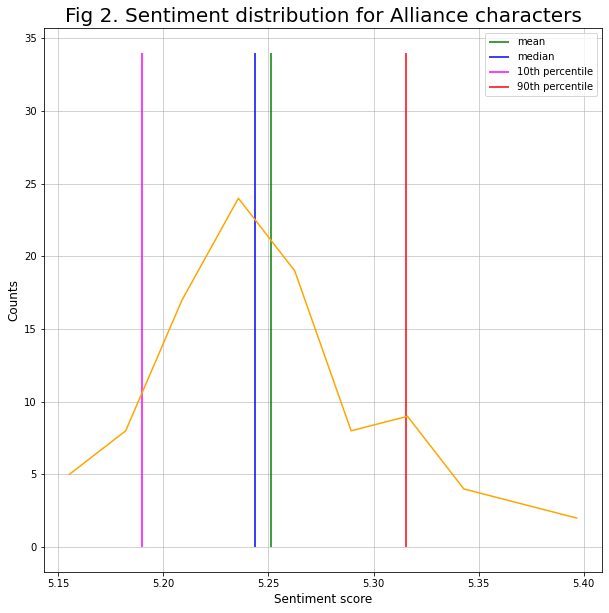

In [31]:
height, bins = np.histogram(a_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 2. Sentiment distribution for Alliance characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='10th percentile')
plt.vlines(p90, 0, max(height)+10, color='red', label='90th percentile')
plt.legend();


## Horde characters

We also compute the mean, median, 10th percentile, and 90th percentile for the bad characters and plot the distribution of sentiment values.

In [32]:
# calculate mean, median, 10th percentile, 90th percentile for bad characters
h_sent = [b for b in h_sent if b != 0] # remove 0s
mean = np.mean(h_sent)
median = np.median(h_sent)
p10 = np.percentile(h_sent, q=10)
p90 = np.percentile(h_sent, q=90)

print("Statistics for horde characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for horde characters
Mean: 5.223
Median 5.237
10th percentile 5.126
90th percentile 5.318


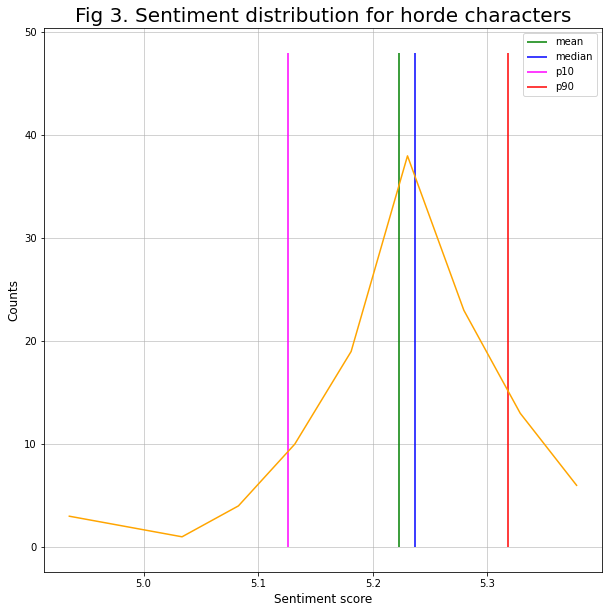

In [33]:
height, bins = np.histogram(h_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 3. Sentiment distribution for horde characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='p10')
plt.vlines(p90, 0, max(height)+10, color='red', label='p90')
plt.legend();
# plt.xlim(min_, max_+1);

The Distributions for Horde and Alliance character sentiment scores are somewhat similar, both peaking at just below 5.25. We now perform permutation tests to see if either faction has significantly lower sentiment scores than the other.

In [34]:
def get_horde_and_alliance_graph(G):

    alliance_subgraph = [n for n in DG.nodes() if n in Alliance.values]
    alliance = G.subgraph(alliance_subgraph)

    horde_subgraph = [n for n in DG.nodes() if n in Horde.values]
    horde = G.subgraph(horde_subgraph)

    return alliance, horde

In [35]:
def get_permuted_sentiments(graph):
    # get number of nodes of graph
    M = len(graph.nodes())
    print("Number of characters:", M)
    
    permuted_sentiments = []
    # permute 1000 times
    for i in tqdm(range(1000)):
        # randomly choose M nodes from graph G
        permute = random.sample(list(DG.nodes()), M)
        
        # get sentiment and append
        sentiment = np.mean([DG.nodes()[node]['sentiment'] for node in permute if DG.nodes()[node]['sentiment'] != 0])
        permuted_sentiments.append(sentiment)
    
    return permuted_sentiments

In [37]:
# get Alliance and Horde partition
alliance, horde = get_horde_and_alliance_graph(DG)

# get sentiments of Alliance and Horde characters respectively
avg_sentiment_A = [DG.nodes[node]['sentiment'] for node in alliance.nodes()]
avg_sentiment_H = [DG.nodes[node]['sentiment'] for node in horde.nodes()]

In [38]:
# mean sentiment values
print("Mean sentiment value for alliance characters:", round(np.mean(avg_sentiment_A),3))
print("Mean sentiment value for horde characters:", round(np.mean(avg_sentiment_H),3))

Mean sentiment value for alliance characters: 5.251
Mean sentiment value for horde characters: 5.223


Number of characters: 99


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2434.13it/s]


The mean of the distribution is: 5.254


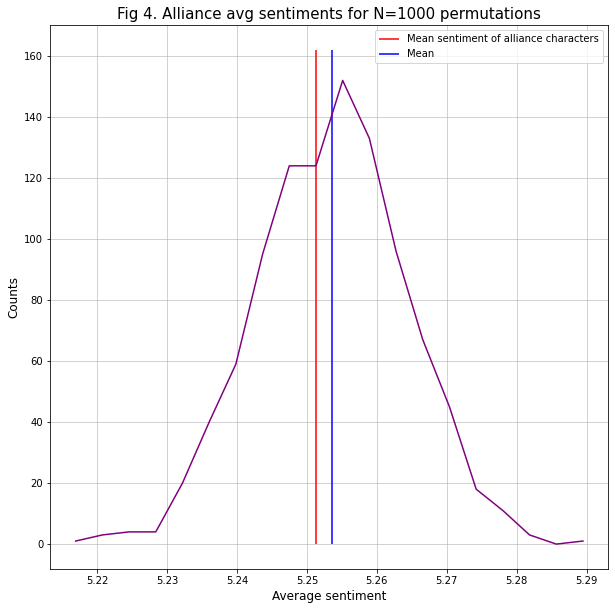

In [39]:
#Alliance
sentiment_As = get_permuted_sentiments(alliance)

print("The mean of the distribution is:", round(np.mean(sentiment_As),3))

minX, maxX  = min(sentiment_As), max(sentiment_As)

height, bins = np.histogram(sentiment_As, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 4. Alliance avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(avg_sentiment_A), 0, max(height)+10, color='red', label='Mean sentiment of alliance characters')
plt.vlines(np.mean(sentiment_As), 0, max(height)+10, color='blue', label='Mean')
plt.legend()
plt.rc('axes', axisbelow=True)

We observe that the mean sentiment score for Alliance characters is close to the mean for the whole data set.

Number of characters: 119


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2308.19it/s]


The mean of the distribution is: 5.254


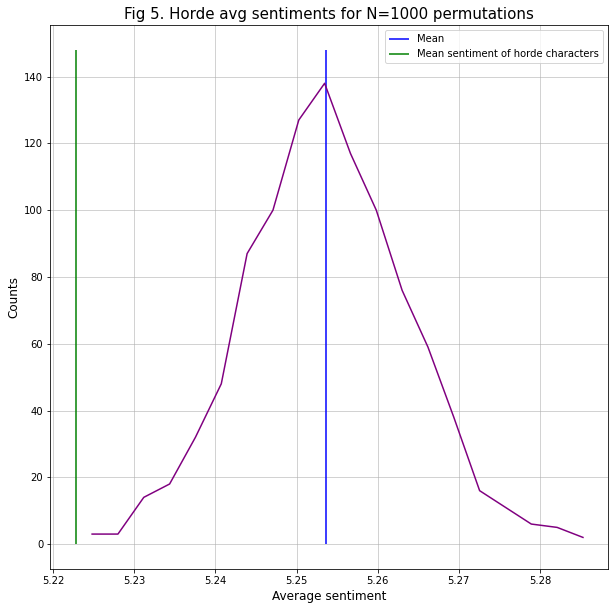

In [40]:
# Horde
sentiment_Hs = get_permuted_sentiments(horde)

print("The mean of the distribution is:", round(np.mean(sentiment_Hs),3))

minX, maxX  = min(sentiment_Hs), max(sentiment_Hs)

height, bins = np.histogram(sentiment_Hs, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 5. Horde avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(sentiment_Hs), 0, max(height)+10, color='blue', label="Mean")
plt.vlines(np.mean(avg_sentiment_H), 0, max(height+10), color='green', label="Mean sentiment of horde characters")
plt.legend()
plt.rc('axes', axisbelow=True)

On the contrary, the average sentiment for the Horde characters is significantly below the mean. From this we can conclude that the Horde characters have a significantly lower sentiment score than the Alliance characters. This result indicates that Alliance characters are described more positively than Horde characters.

### Directed Sentiment: Sentiment between factions
Are the horde more hostile towards the alliance or opposite. Do they always interact in negative situations or do they share good times? In order to measure this, we find the sentences in each characters text that mention other characters and calculate the sentiment for those. The resulting score is added as an attribute to the directed edge from one character to the other. 

In [41]:
#load dictionary of character aliases. Needed later
with open('max_char2aliases.pickle', 'rb') as f:
    max2A_dic = pickle.load(f)

In [144]:
success_count = 0
fail_count = 0
attribute_dic = {} #define dictionary to save sentiment scores
for name in tqdm(DG.nodes()): #loop over characters
    for char in df_text['Out Links'][df_text['Name']==name].values[0]: #Loop over the characters link to
        reg_exp = '[^.]*{}.[^.]*\.'.format(char.replace('_',' ')) #Use regex to find sentences where the characters are mentioned
        text = str(df_text['Clean Text'][df_text['Name']==name].values).replace('\\','')
        match = re.findall(reg_exp, text)
#         print(name,char,match)
        
 
        try:
            aliases = max2A_dic[char] #if character has aliases, check if their aliases are mentioned
            for alias in aliases:
                reg_exp = '[^.]*{}.[^.]*\.'.format(alias.replace('_',' '))
                alias_match = re.findall(reg_exp, text)
                for item in alias_match:
                    if item not in match:#Only add sentences that were not already found. Necessary as some characters aliases are subsets of their name(e.g first name only).
#                         print('Alias:',item,'Match:', match, name, char)
                        match.append(item)
                        
#                     print('success for:',name,char)
        except:
                None
        if match!=[]:
            tokens = [t.split() for t in match]#split text into tokens
            tokens = [item for sublist in tokens for item in sublist]
            freqdist_dic = nltk.FreqDist(tokens) 
            sentiment_score = text2sentiment_freqdist(freqdist_dic)#calculate sentiment score for all tokens.
            attribute_dic[(name,char)]=(sentiment_score,match)#save sentiment score for edge
            success_count +=1
        else:#If the character is linked to on a characters page, but does not appear in the clean text, we ignore that particular edge.
#             print('oops, problem with',name,char)
            fail_count +=1
   

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [29:58<00:00,  1.09it/s]


There are 643 links where the linked characters are not mentioned in the clean text. These are simply disregarded for the directed sentiment analysis.

In [145]:
nx.set_edge_attributes(DG, attribute_dic, 'Sentiment_edge')#Save the sentiment as edge attributes

In [147]:
#save graph with edge attributes and the attribute dictionary
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\edge_sent_dic.pickle', 'wb') as handle:
    pickle.dump(attribute_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [147]:
#save graph with edge attributes and the attribute dictionary
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\edge_sent_dic.pickle', 'wb') as handle:
    pickle.dump(attribute_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [148]:
#Calculate means for faction to faction sentiment
for edge in DG.edges():
    if edge in attribute_dic.keys():#check if sentiment has been calculated for the edge
        if edge[0] in Alliance.values and edge[1] in Alliance.values:#Alliance to alliance sentiment
            A2A.append(attribute_dic[edge][0])
        elif edge[0] in Alliance.values and edge[1] in Horde.values:#Alliance to horde sentiment
            A2H.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Alliance.values:#Horde to alliance sentiment
            H2A.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Horde.values:#Horde to horde sentiment
            H2H.append(attribute_dic[edge][0])
print('Mean sentiment for Alliance to Alliance:',np.mean(A2A))
print('Mean sentiment for Alliance to Horde:',np.mean(A2H))
print('Mean sentiment for Horde to Alliance:',np.mean(H2A))
print('Mean sentiment for Horde to Horde:',np.mean(H2H))
        

Mean sentiment for Alliance to Alliance: 5.244740014158619
Mean sentiment for Alliance to Horde: 5.2214226725570105
Mean sentiment for Horde to Alliance: 5.204189698125854
Mean sentiment for Horde to Horde: 5.227197251684637


We can see that the sentiment from the Alliance to the Alliance is the highest among the mean directed sentiments from faction to faction. This is somewhat expected as Alliance characters in general have higher average sentiment scores.

In [149]:
#Sanity check, delete?
for edge in DG.edges():
    print(attribute_dic[edge][0])
    break
('Brann_Bronzebeard','Dagran_Thaurissan_II') in nx.get_edge_attributes(DG,'Sentiment_edge').keys()

5.354210526315788


False

In [43]:
#Load previoulsy saved dicts
with open('DG_sent.pickle', 'rb') as f:
    DG = pickle.load(f)
with open('edge_sent_dic.pickle', 'rb') as f:
    attribute_dic = pickle.load(f)

Now that we have calculated the sentiment for each character pair, we can find the mean directed sentiment for major characters of each faction that appear in each game/expansion, as we did with regular sentiment score before.

In [150]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
#same games list as earlier
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS']


games_sent_d = {}
games_sent_A2A = {}
games_sent_A2H = {}
games_sent_H2A = {}
games_sent_H2H = {}
character_sent = {}
for game in tqdm(games):
    A2A = []
    A2H = []
    H2A = []
    H2H = []
    h = []
    a = []
    for edge in DG.edges():
        if edge[0] in df_meta[df_meta[game]==1].Name.values and edge in attribute_dic.keys():           
            if edge[0] in Alliance.values and edge[1] in Alliance.values:
                A2A.append(attribute_dic[edge][0])
            elif edge[0] in Alliance.values and edge[1] in Horde.values:
                A2H.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Alliance.values:
                H2A.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Horde.values:
                H2H.append(attribute_dic[edge][0])
    #Save mean directed sentiment for each faction to faction combination
    games_sent_A2A[game]=np.mean(A2A)
    games_sent_A2H[game]=np.mean(A2H)
    games_sent_H2A[game]=np.mean(H2A)
    games_sent_H2H[game]=np.mean(H2H)
games_sent_d = {'A2A':games_sent_A2A, 'A2H':games_sent_A2H,'H2A':games_sent_H2A, 'H2H':games_sent_H2H }


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:26<00:00,  6.19s/it]


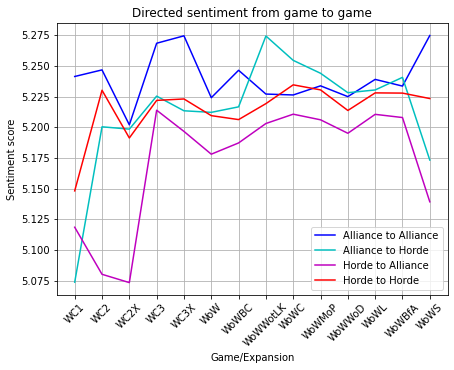

In [152]:
#plot directed sentiment over time.
plt.figure(figsize=(7,5))
plt.plot(games_sent_d['A2A'].values(),'b')
plt.plot(games_sent_d['A2H'].values(),'c')
plt.plot(games_sent_d['H2A'].values(),'m')
plt.plot(games_sent_d['H2H'].values(),'r')
plt.title('Directed sentiment from game to game')
# plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean Sentiment score')
plt.legend(['Alliance to Alliance','Alliance to Horde','Horde to Alliance','Horde to Horde','Mean sentiment score'])
plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.show()

We see that the Alliance to Horde sentiment is surprisingly high for WoWWotLK. We want to look closer as to why. To do this, we find the Alliance to Horde edge with the highest sentiment score.

In [189]:

temp_list=[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Alliance.values]
temp_list2 =[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Horde.values]
# Horde.values
temp_edges=[edge for edge in attribute_dic.keys() if edge[0] in temp_list and edge[1] in temp_list2]
temp_edges
# [(name,value) for ]
A2H_max_s=sorted([attribute_dic[item] for item in temp_edges])
    
print(A2H_max_s[-1],A2H_max_s[-2])


(5.586666666666666, ["nnThe Vow EternalnnMuradin and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."]) (5.586666666666666, ["nnThe Vow EternalnnBrann and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."])


The edge with the highest sentiment score is actually to edges with almost identical text. This is for both Muradin and Brann Bronzebeard to Lor'themar Theron. The text explains that the dwarves attended Lor'themar's wedding.